In [8]:
import numpy as npi
import seaborn as sns
import cv2, os, glob, datetime
import matplotlib.pyplot as plt
from keras import layers, Input
from tensorflow.keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import InceptionV3
from keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Activation, Dropout, GlobalAveragePooling2D

In [12]:
import numpy as np
import cv2
import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionV3

# Initialize model
inp = 299
model = InceptionV3(weights="imagenet", include_top=False, input_shape=(inp, inp, 3))

# Folder paths
folders = glob.glob(r"D:\ROCT_implementation\OCTID\augmented\*")

# Initialize lists for storing images and labels
img_list = []
label_list = []

# Loop through the folders and read images
for folder in folders:
    print(f"Processing folder: {folder}")
    
    # Read both .png and .jpg images
    image_paths = glob.glob(folder + r"/*.jpg") + glob.glob(folder + r"/*.png")
    
    if not image_paths:
        print(f"No images found in {folder}")
    
    for img in image_paths:
        n = cv2.imread(img)
        if n is None:
            print(f"Failed to read image: {img}")
            continue
        
        class_num = folders.index(folder)
        label_list.append(class_num)
        
        # Resize image to 299x299 as required by the model
        resized = cv2.resize(n, (299, 299), interpolation=cv2.INTER_AREA)
        img_list.append(resized)

# Check if img_list and label_list are populated
if not img_list or not label_list:
    raise ValueError("No images found. Check the paths and image files.")

# Split data into training (70%) and testing (30%) sets
X_train, X_temp, y_train, y_temp = train_test_split(img_list, label_list, test_size=0.3, random_state=1)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Print the shapes of the datasets
print("training_set", X_train.shape)
print("training_set", y_train.shape)
print("validation_set", X_valid.shape)
print("validation_set", y_valid.shape)
print("test_set", X_test.shape)
print("test_set", y_test.shape)
print("Train_Folder", len(X_train))
print("validation_Folder", len(X_valid))
print("Test_Folder", len(X_test))



Processing folder: D:\ROCT_implementation\OCTID\augmented\augmentedNormal
Processing folder: D:\ROCT_implementation\OCTID\augmented\augmetnedADM
Processing folder: D:\ROCT_implementation\OCTID\augmented\augmetnedCRS
Processing folder: D:\ROCT_implementation\OCTID\augmented\augmetnedDRS
Processing folder: D:\ROCT_implementation\OCTID\augmented\augmetnedMRS
training_set (14330, 299, 299, 3)
training_set (14330,)
validation_set (3071, 299, 299, 3)
validation_set (3071,)
test_set (3071, 299, 299, 3)
test_set (3071,)
Train_Folder 14330
validation_Folder 3071
Test_Folder 3071


In [14]:
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, BatchNormalization, Conv2D, Layer
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import tensorflow as tf

# Set the input dimensions
inp = 299  # Example input size; adjust as needed

# Define the Pyramid Attention layer
class PyramidAttention(Layer):
    def __init__(self, **kwargs):
        super(PyramidAttention, self).__init__(**kwargs)

    def call(self, inputs):
        # Average pooling at different scales
        scale1 = tf.image.resize(inputs, (inputs.shape[1] // 2, inputs.shape[2] // 2))  # Scale 1
        scale1 = tf.reduce_mean(scale1, axis=[1, 2], keepdims=True)

        scale2 = tf.image.resize(inputs, (inputs.shape[1], inputs.shape[2]))  # Scale 2
        scale2 = tf.reduce_mean(scale2, axis=[1, 2], keepdims=True)

        scale3 = tf.image.resize(inputs, (inputs.shape[1] * 2, inputs.shape[2] * 2))  # Scale 3
        scale3 = tf.reduce_mean(scale3, axis=[1, 2], keepdims=True)

        # Concatenate the pooled features
        pyramid_features = layers.concatenate([scale1, scale2, scale3], axis=-1)
        return pyramid_features

# Define your input layer
inputs = Input((inp, inp, 3))

# Use the base InceptionV3 model without the top layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(inp, inp, 3))

# Get the output from the base model
X = base_model(inputs)

# Apply Pyramid Attention
X = PyramidAttention()(X)

# Your custom architecture continues here
flat1 = GlobalAveragePooling2D()(X)
x3 = GlobalMaxPooling2D()(X)

# Dense layers after global pooling
x1 = Dense(100, activation='relu')(flat1)
x1 = Dense(50, activation='relu')(x1)
x1 = BatchNormalization()(x1)

# Additional convolutional layers
x2 = Conv2D(filters=64, kernel_size=(1, 1), activation='relu', padding='same')(X)
x2 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x2)
x2 = Conv2D(filters=64, kernel_size=(1, 1), activation='relu', padding='same')(x2)

# Global pooling and batch normalization for x2
x2 = GlobalAveragePooling2D()(x2)
x2 = BatchNormalization()(x2)

# Combine features
BAM = layers.concatenate([x1, x2])
BAM = BatchNormalization()(BAM)
BAM = layers.concatenate([x3, BAM])

# Final dense layers
F = Dense(150, activation='relu')(BAM)
F = BatchNormalization()(F)
output = Dense(5, activation='softmax')(F)

# Create the final model
model = Model(inputs=inputs, outputs=output)

# Display the model summary
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
inception_v3 (Functional)       (None, 8, 8, 2048)   21802784    input_7[0][0]                    
__________________________________________________________________________________________________
pyramid_attention_1 (PyramidAtt (None, 1, 1, 6144)   0           inception_v3[0][0]               
__________________________________________________________________________________________________
conv2d_567 (Conv2D)             (None, 1, 1, 64)     393280      pyramid_attention_1[0][0]        
____________________________________________________________________________________________

In [15]:
import tensorflow as tf
tf.keras.backend.clear_session()


In [16]:
batch_size = 8
epochs = 30
opt = SGD(learning_rate=0.0001, momentum=0.9)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history=model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,verbose=1,validation_data=(X_valid,y_valid))
model.save("adxnan.h5")

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

<Figure size 2160x2160 with 0 Axes>

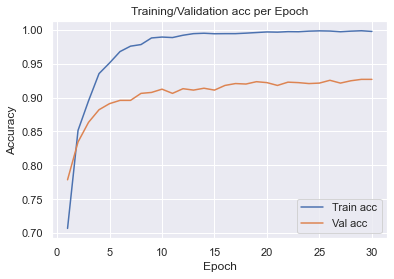

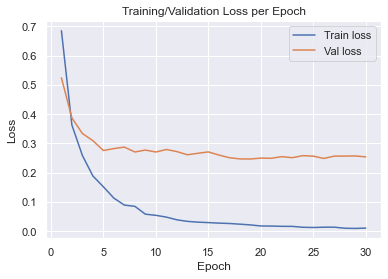

***** Confusion Matrix *****
[[278  42   9]
 [ 53 574   2]
 [ 11   2 479]]
***** Classification Report *****
                precision    recall  f1-score   support

Blood on Human       0.81      0.84      0.83       329
Blood on Floor       0.93      0.91      0.92       629
 Blood at item       0.98      0.97      0.98       492

      accuracy                           0.92      1450
     macro avg       0.91      0.91      0.91      1450
  weighted avg       0.92      0.92      0.92      1450



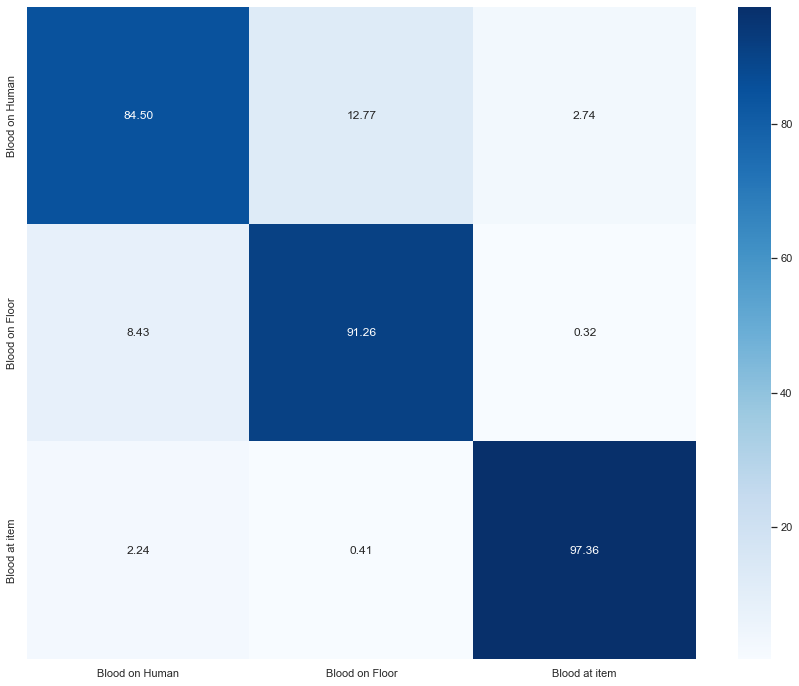

46/46 [==============================] - 2s 52ms/step - loss: 0.2416 - accuracy: 0.9179

Testing loss: 0.2416
Testing accuracy: 0.9179


In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import  confusion_matrix
import matplotlib.pyplot as plot
import seaborn as sn
import pandas as pd
import seaborn as sns
from sklearn.metrics import  confusion_matrix
from sklearn.metrics import classification_report 
import numpy as np
plt.figure(figsize=(30,30))
sns.set(font_scale=1.0)

f, ax = plt.subplots()
ax.plot([None] + history.history['accuracy'])
ax.plot([None] + history.history['val_accuracy'])
# Plot legend and use the best location automatically: loc = 0.
ax.legend(['Train acc', 'Val acc'], loc = 0)
ax.set_title('Training/Validation acc per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
f, ax = plt.subplots()
ax.plot([None] + history.history['loss'])
ax.plot([None] + history.history['val_loss'])
# Plot legend and use the best location automatically: loc = 0.
ax.legend(['Train loss', "Val loss"], loc = 1)
ax.set_title('Training/Validation Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.show()


y_pred=model.predict(X_test)
y_pred=np.argmax(y_pred, axis=1)

target_names = ["Blood on Human","Blood on Floor","Blood at item" ] 
cm = confusion_matrix(y_test, y_pred)
print("***** Confusion Matrix *****")
print(cm)
print("***** Classification Report *****")
print(classification_report(y_test, y_pred, target_names=target_names))
classes=3
con = np.zeros((classes,classes))
for x in range(classes):
    for y in range(classes):
        con[x, y] = cm[x, y] / np.sum(cm[x, :]) * 100  # Calculate percentage

plt.figure(figsize=(15, 12))
df = sns.heatmap(con, annot=True, fmt='.2f', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
df.figure.savefig("DFAN.png")
plt.show()
print('\nTesting loss: {:.4f}\nTesting accuracy: {:.4f}'.format(*model.evaluate(X_test, y_test)))

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# Function to preprocess the image
def get_img_array(img_path, size):
    img = load_img(img_path, target_size=size)
    array = img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return preprocess_input(array)

# Function to create the Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Function to superimpose the heatmap on the original image
def get_superimposed_img(img_path, heatmap, alpha=0.4):
    img = load_img(img_path)
    img = img_to_array(img)

    heatmap = np.uint8(255 * heatmap)
    jet = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    jet = cv2.cvtColor(jet, cv2.COLOR_BGR2RGB)

    jet_heatmap = cv2.resize(jet, (img.shape[1], img.shape[0]))
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = np.uint8(superimposed_img)

    return superimposed_img

# Load your trained model (update the path if needed)
model = tf.keras.models.load_model('adxnan.h5')

# Choose the last convolutional layer
last_conv_layer_name = "conv2d_96"  # Or "mixed10" for the InceptionV3 layer

# Specify the root directory containing subdirectories with images
root_dir = 'D:/adnan blood detection/'  # Replace with your root directory

# Loop through each subdirectory
for subdir, dirs, files in os.walk(root_dir):
    # Filter image files in the current subdirectory (allow only jpeg, jpg, png)
    img_files = [os.path.join(subdir, f) for f in files if f.endswith(('.jpeg', '.jpg', '.png'))]

    # If there are more than 3 images, select the first 3
    if len(img_files) >= 3:
        img_files = img_files[:3]

    # Generate Grad-CAM for each of the 3 images
    for i, img_path in enumerate(img_files):
        # Preprocess the image
        img_array = get_img_array(img_path, size=(299, 299))

        # Generate Grad-CAM heatmap
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

        # Get the superimposed image
        superimposed_img = get_superimposed_img(img_path, heatmap)

        # Plot the original and Grad-CAM superimposed images
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(load_img(img_path))
        plt.title(f'Original Image {i+1}')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(superimposed_img)
        plt.title(f'Grad-CAM Superimposed {i+1}')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

